
# LangGraph: Quick start

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropice

In [2]:
import getpass
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Access the keys to not input them every time
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

## Building Basic Chatbot

First thing we do is define the `State`. In our case a `TypedDict` with a single key: `message`. It is annoted with the `add_messages` reducer function to append messages rather than overwrite them.

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Let's use add_messages to append messages to the list and not overwrite it
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [4]:
from langchain_anthropic import ChatAnthropic

os.environ['SSL_CERT_FILE'] = '/etc/ssl/certs/ca-certificates.crt' # needed for anthropic api
os.environ['REQUESTS_CA_BUNDLE'] = "/etc/ssl/certs/ca-certificates.crt" # needed for langsmith api

#os.environ['HTTPX_SSL_VERIFY'] = '/etc/ssl/certs/ca-certificates.crt' # not needed now

llm = ChatAnthropic(model="claude-3-5-sonnet-20241022",
                    temperature=0)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# 1st argument is the unique node and 2nd func or object to call
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

#Complie the graph
graph = graph_builder.compile()

To plot the diagram with Mermaid, you need to install a few dependencies. See the [LangChain LangGraph Visualization Guide](https://langchain-ai.github.io/langgraph/how-tos/visualization/).

> **Note:** Firewalls or VPNs might restrict the API call. If you encounter issues, consider the following options:
> 
> - **Testing only:** Use `verify=False` in your API call (not recommended due to security risks).
> - Download the proper certificate from Mermaid and add it with:
>   ```python
>   os.environ['REQUESTS_CA_BUNDLE'] = "/etc/ssl/certs/ca-certificates.crt"
>   ```
> - Without API via Pyppeteer


/home/dani/repos/langchain-academy/lc-academy-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mermaid.ink'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


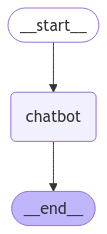

In [ ]:
from IPython.display import Image, display
import requests

# Monkey-patch requests within the draw_mermaid_png method (if possible)
original_request = requests.get

def request_with_ssl_disabled(*args, **kwargs):
    kwargs['verify'] = False  # Disable SSL verification for all requests
    return original_request(*args, **kwargs)

# Apply the patch
requests.get = request_with_ssl_disabled

display(Image(graph.get_graph().draw_mermaid_png()))


/home/dani/repos/langchain-academy/lc-academy-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mermaid.ink'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


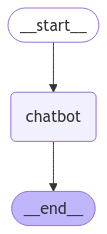

In [ ]:
# Alternative way
try:
    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
finally:
    # Revert to the original requests.get to maintain code hygiene
    requests.get = original_request


Adding the cert better!

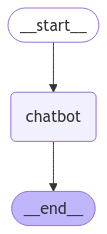

In [12]:

display(Image(graph.get_graph().draw_mermaid_png()))

Or use the Mermaid + Pyppeteer

In [ ]:

%%capture --no-stderr
%pip install --quiet pyppeteer
%pip install --quiet nest_asyncio

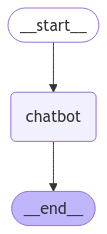

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

Run chatbot!

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What is the meaning of life?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: "El Bicho" es el apodo popular de Cristiano Ronaldo, uno de los futbolistas más famosos y exitosos de la historia. Nacido el 5 de febrero de 1985 en Funchal, Madeira (Portugal), Cristiano Ronaldo es conocido por:

1. Su extraordinaria carrera en clubes como:
- Manchester United
- Real Madrid
- Juventus
- Al Nassr (actualmente)

2. Logros destacados:
- 5 UEFA Champions League
- 5 Balones de Oro
- Múltiples títulos de liga en diferentes países
- Máximo goleador histórico del fútbol profesional

3. Con la selección portuguesa:
- Campeón de la Eurocopa 2016
- Campeón de la UEFA Nations League 2019
- Máximo goleador histórico en selecciones nacionales

El apodo "El Bicho" surgió en España y hace referencia a su intensidad, determinación y capacidad física excepcional en el campo. Es considerado uno de los mejores futbolistas de todos los tiempos, junto con Lionel Messi, y ha dejado un legado importante en el deporte.
Goodbye!


## Adding Tools

In [7]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [8]:
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")

In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What is the meaning of life?")

[{'url': 'https://www.wired.com/story/what-is-the-meaning-of-life/',
  'content': 'On top of this, the actual elements that make Earth and life on Earth represent only a tiny fraction of a per cent of the composition of the Universe.\n This article was originally published by WIRED UK\nMatt Reynolds\nEmily Mullin\nMatt Simon\nMatt Simon\nMatt Simon\nAnita Hofschneider\nMatt Simon\nMore From WIRED\nReviews and Guides\n© 2024 Condé Nast. Joel Khalili\nParesh Dave\nDell Cameron\nJennifer M. Wood\n“When I was a student starting out in astronomy, the recipe of the Universe was simple,” she says.\xa0 Subscribe to WIRED\nThanks to modern censuses of planets in our galactic neighbourhood, like Nasa\'s Kepler mission, we know that planets are common and that small, Earth-sized planets are not the exception, but the rule.\n "Contemplating the sheer scale of the Universe and the tininess of our world, it is easy to dismiss humanity as insignificant in the ‘Big Picture’.'},
 {'url': 'https://1000w

In [35]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Let's use Haiku here and bind the tools
llm = ChatAnthropic(model="claude-3-5-haiku-latest")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

We should define to run the tools if called. Let's implemente a ``BasicToolNode`` which would check the latest message and if it contains ``tool_calls``.

In [36]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools and returns the results."""
    

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages"):
            message = messages[-1]
        else:
            raise ValueError("No messages found in the input.")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"])
                )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tool_node", tool_node)

# The previous piece of code


Let's add some conditional edges calling ``route_tools`` which would check for ``tool_calls``

In [37]:
from typing import Literal

def route_tools(state: State):
    """Use the conditional edge to route to the Tool Node
      if the last message contains a tool call."""

    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages"):
        ai_message = messages[-1]
    else:
        raise ValueError("No messages found in the input to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# Add a directed edge from the START node to the "chatbot" node
graph_builder.add_edge(START, "chatbot")

# Add conditional edges from the "chatbot" node using the route_tools function
# If route_tools returns "tools", go to "tool_node". This renaming is optional
# If route_tools returns END, go to END
graph_builder.add_conditional_edges("chatbot", route_tools,
                                    {"tools": "tool_node", END: END})

# Add a directed edge from the "tools" node back to the "chatbot" node
graph_builder.add_edge("tool_node", "chatbot")

# Recompile the graph to include the new nodes and edges
graph = graph_builder.compile()

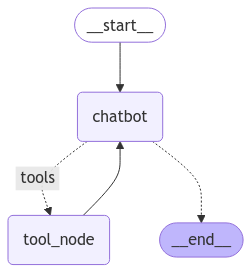

In [38]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [39]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User:")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What is the meaning of life?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: ¡Hola! How can I help you today? I'm ready to assist you with any questions or tasks you might have. Would you like to search for information, get help with something, or just chat?
Assistant: [{'text': 'Let me search for information about "el bicho" to provide you with an accurate answer.', 'type': 'text'}, {'id': 'toolu_01L6rZ5gAiVZHQPqQp4mBjya', 'input': {'query': 'El Bicho nickname Cristiano Ronaldo meaning'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://www.latestly.com/sports/football/cristiano-ronaldo-nickname-why-portuguese-star-is-called-el-bicho-and-what-does-it-mean-in-english-3882116.html", "content": "Ronaldo's other nicknames: ' El bicho,' is not the only nickname Ronaldo has been named with; he has a few more. The most famous nickname which is widely used to call the greatest goalscorer, is 'Cr7.' This is like an acronym of Cristiano Ronaldo 7 (Jersey No. 7). Many fans and football pundits call him 'GOAT' which means 

Here you see that the previous response made the model to call tools and find info about it -- it's on model's decision whether call or not

> **Note:** As you can see, the model decided to call tools in the previous response to find relevant information. It's ultimately up to the model to determine whether or not to make a tool call, based on the context of the conversation and the user's request.

Let's try something simpler to trigger a no-call response:

In [40]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User:")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What is the meaning of life?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: ¡Hola! How are you doing today? I'm here to help you with any questions or tasks you might have. Is there something specific you'd like assistance with?
Assistant: 2 + 2 = 4. This is a basic arithmetic operation that can be solved without needing to use any search tools. The sum of 2 and 2 is always 4.
Assistant: 2 plus 2 equals 4. This is a basic arithmetic operation that doesn't require any search tool. It's a simple addition problem where you add the two numbers together, resulting in 4.
Goodbye!
